#### Generate labeled and unlabeled data by random selecting 42 samples without replacement and removing their class to perform as unlabeled data. The non-selected 20 samples will be used as labeled data (42:20).

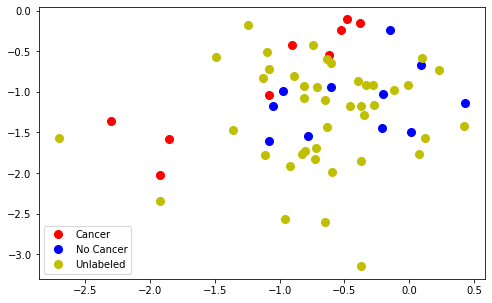

In [436]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import random
import warnings
warnings.filterwarnings('ignore')

rng = np.random.RandomState(10)

colon_data = pd.read_csv('../data/colon.csv')
X = colon_data[['T62947', 'H64807']].to_numpy()
y = colon_data[['Class']].to_numpy()

random.seed(30)
index = random.sample(range(len(y)), 42)
labeled = random.sample([x for x in range(max(index)) if x not in index], 20)
X_labeled, y_labeled = X[labeled], y[labeled]
X_unlabel, y_unlabel = X, y.copy()
y_unlabel[index] = 0

def plot_data(X, y):
    y = y.flatten()
    class1 = (y ==  1)
    class2 = (y == -1)
    class3 = (y ==  0)
    plt.figure(figsize=(8, 5))    
    plt.plot(X[:,0][class1], X[:, 1][class1], 'ro', markersize = 8, label = 'Cancer')
    plt.plot(X[:,0][class2], X[:, 1][class2], 'bo', markersize = 8, label = 'No Cancer')
    plt.plot(X[:,0][class3], X[:, 1][class3], 'yo', markersize = 8, label = 'Unlabeled')
    plt.legend(loc = 'lower left')

plot_data(X_unlabel, y_unlabel)

#### Perform SVM by using 20 labelled samples.

<Figure size 1080x720 with 0 Axes>

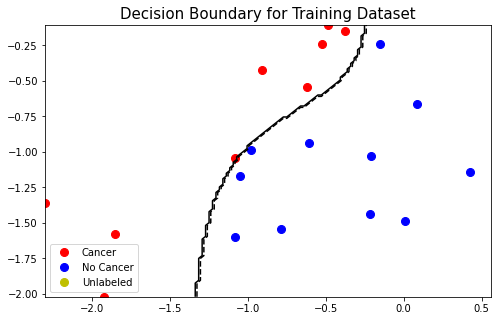

In [437]:
random.seed(413)
svclassifier = SVC(kernel = 'rbf', C = 100, gamma = 1)
svclassifier.fit(X_labeled, y_labeled)

def visualize_boundary(X, y, model, title):
    plt.figure(figsize = (15, 10))
    plot_data(X, y)
    X_21, X_22 = np.meshgrid(np.linspace(X[:,0].min(), X[:,1].max(), num = 100), 
                             np.linspace(X[:,1].min(), X[:,1].max(), num = 100))
    plt.contour(X_21, X_22, model.predict(np.array([X_21.ravel(),X_22.ravel()]).T).reshape(X_21.shape), 1, colors = 'k')
    plt.title(title, size = 15)
    plt.legend(loc = 'lower left')
    plt.show()

random.seed(413)
visualize_boundary(X_labeled, y_labeled, svclassifier, title = 'Decision Boundary for Training Dataset')

In [438]:
predictions = svclassifier.predict(X_labeled)
print(classification_report(y_labeled, predictions, target_names = ['No Cancer', 'Cancer']))

              precision    recall  f1-score   support

   No Cancer       1.00      1.00      1.00        11
      Cancer       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [441]:
def label_propagate(X, y, rate):
    y_new = np.copy(y)
    y_new[rng.rand(len(y)) < rate] = 0
    ls_ix = (LabelSpreading().fit(X, y_new), y_new)
    return y_new, ls_ix

y30, ls30 = label_propagate(X, y, rate = 0.30)
y50, ls50 = label_propagate(X, y, rate = 0.50)
y75, ls75 = label_propagate(X, y, rate = 0.75)

rbf_svc = (SVC(kernel = 'rbf', gamma = 0.5).fit(X, y), y)

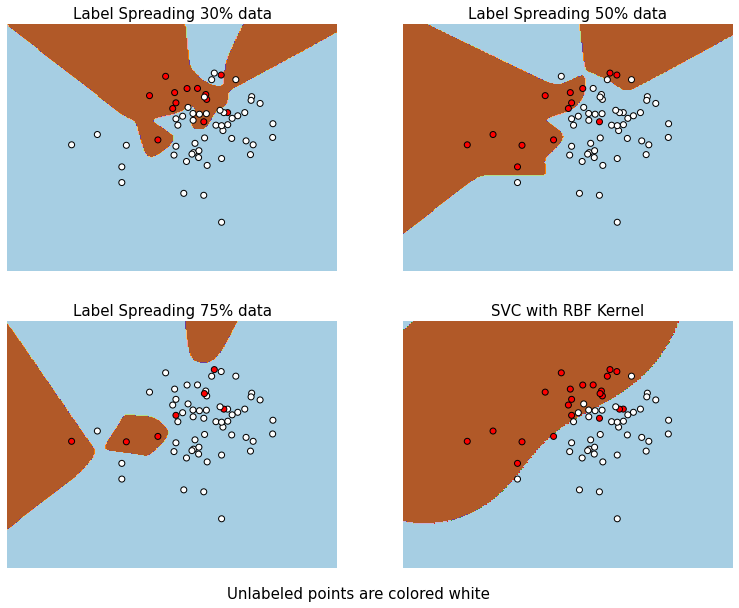

In [453]:
x_min, x_max = X[:, 0].min() -1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() + 1

h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
titles = ['Label Spreading 30% data', 'Label Spreading 50% data', 'Label Spreading 75% data', 'SVC with RBF Kernel']

plt.figure(figsize = (13, 10))
for i, (clf, y_train) in enumerate((ls30, ls50, ls75, rbf_svc)):
    plt.subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired)
    plt.axis('off')

    colors = []
    for y in y_train:
        if   y == -1:
            color = (1, 1, 1)
        elif y ==  0:
            color = (1, 1, 1)
        elif y ==  1:
            color = (1, 0, 0)
        colors.append(color)
    plt.scatter(X[:, 0], X[:, 1], c = colors, edgecolors = 'black')
    plt.title(titles[i], size = 15)

plt.suptitle("Unlabeled points are colored white", y = 0.1, size = 15)
plt.show()
